# Transfer Learning

**Outline**

* [Intro](#intro)
* [Problem Description](#problem)
* [Specify the Model](#specify)
* [Compile the Model](#compile)
* [Fit Model](#original)
* [Fit Model with Data Augmentation](#augment)
* [Make prediction using the trained model](#predict)
* [Reference](#refer)

---

## <a id='intro'>Introduction</a>

Most the following content are my note when following the Deep Learning tutorial from Kaggle. Let's get started!

According to [wikipedia](https://en.wikipedia.org/wiki/Transfer_learning), 

```
Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks.
```

In other words, Transfer Learning takes what a model learns while solving one problem and applies it to a new application. Remember that early layes of a deep learning model identify simple shapes; later layers identify more complex visual patterns and the very last layer makes predictions. That's why most layers from a pre-trained model are useful in new applications, because most computer vision problems involve similar low-level visual patterns. 

In this example, we are going to use most of the pre-trained layer from the model built using ImageNet, called ResNet50 model, to solve the problem described below. 

The way we are going to do is to replace the final layer which was used to identify items in a image with the new label we want. In this notebook, we want to help a cameraman to identify whether a dog image is upright or sideways.

## <a id='problem'>Problem Description</a>

A cameraman told us a frustrating problem that we could solve with deep learning.

He offers a service that scans photographs and slides to store them digitally. He uses a machine that quickly scans many photos. But depending on the orientation of the original photo, many images are digitized sideways. He currently spends a lot of time looking find which photos need to be rotated sideways, so he can fix them.

It would save him a lot of time if this process could be automated. In this problem, we will build a model that distinguishes which photos are sideways and which are upright.

## <a id='specify'>Specify the Model</a>

As mentioned above, we are going to used a pre-trained model [**ResNet-50**](https://github.com/KaimingHe/deep-residual-networks) to help us solve the problem.

In [2]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

# Specify the file path that contains the weights of the ResNet-50 model which doesn't include the weights for the last layer.
num_classes = 2
resnet_weights_path = 'data/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create a new model and add ResNet50 as our layer.
# We don't want to include the top layer, which is the original last layer used to make predictions for the previoius problem.
my_model = Sequential()
my_model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
my_model.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
my_model.layers[0].trainable = False

## <a id='complie'>Compile the Model</a>


Complile command tells tensorflow how to update the relationship in the dense connections when we are going the training with our data. We have a measure of loss or inaccuracy we want to minimize.

* **Loss Function**: categorical_crossentropy = log loss
* **Optimization Method**: sgd = stochastic gradient descent
* **metrics**: We can ask the complie method to report the some metrics that is easier to interpret. In this case, we specify *accuracy* as our metrics.

In [3]:
my_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

## <a id='original'>Fit Model</a>

In our case, we have 220 images of training data and 217 of validation data, which we put it in different folder. Here is how our directory structure look like:

```
    ├── train           <- folder containing all the training images (220 images)
    │   ├── sideways      <- images labeled as sideways
    │   │
    │   ├── upright       <- images labeled as upright
    │     
    ├── val             <- folder containing all the validation images (217 images)
    │   ├── sideways      <- images labeled as sideways
    │   │
    │   ├── upright       <- images labeled as upright
    │         
    ├── test             <- folder containing all the test images   
```

Keras has a great tool called `ImageDataGenerator` that can help us deal with images grouped into directories by their label. Another good things about using this tool is that we don't need to read so many images into memory.

There are two steps to use `ImageDataGenerator`:

1. create the ImageDataGenerator as an python object.
2. use `flow_from_directory` to specify 
    * what directory our data is in
    * what size image we want 
    * how many images to read in at a time
    * tell it we're classifying data into different categories
    
In the following example, we have 220 training images and we specify to read 10 images as a time. That's why we need 22 steps to train the model.    

In [5]:
train_dir = 'data/dogs-gone-sideways/train'
val_dir = 'data/dogs-gone-sideways/val'
test_dir = 'data/dogs-gone-sideways/test'

In [6]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_size = 224
data_generator = ImageDataGenerator() 

train_generator = data_generator.flow_from_directory(
       directory = train_dir,
       target_size=(image_size, image_size),
       batch_size= 10,
       class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
       directory = val_dir,
       target_size=(image_size, image_size),
       batch_size= 10,    
       class_mode='categorical')

my_model.fit_generator(
       train_generator,
       steps_per_epoch=22, 
       validation_data=validation_generator,
       validation_steps=22)

Found 220 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Epoch 1/1
22/22 [==============================] - 64s 3s/step - loss: 0.4613 - acc: 0.7682 - val_loss: 0.2127 - val_acc: 0.9401


From the model fitting, we can see that the validation accuracy is 90.3%, which is quite good given that we only use a small amount of images to train..

## <a id='augment'>Fit the Model Using Data Augmentation</a>

Usually, deep neural networks(DNN) need large amount of training images to achieve good performance. To build a good image classifier using very little training data, there is a technique called **Data Augmentation** to help us boost the performance of DNN.

The concept of Data Augmentation is quite straight forward. We can generate more training data by changing the angle of our raw images. For example, we can shirt the image horizontally by 20% either side, vertically by 20% up and down or even flip the raw image over to increase the size of our training data. The image below copied from the [blog: Image Augmentation for Deep Learning](https://towardsdatascience.com/image-augmentation-for-deep-learning-histogram-equalization-a71387f609b2) illustrate the technique clearly:

![](https://cdn-images-1.medium.com/max/1200/1*5RXJ2OlVJp4_sd1XzhK6pQ.png)

Noted that we should only use data augmentation for out training data not on the validation data so that we can compare the new model with the original model. Also, sometime the flips image won't have the same label as the original image. Before doing data augmentation, we should keep these issues in mind.

In [18]:
image_size = 224
# read image and increase the number of training images using data augmentation
data_generator_with_aug = ImageDataGenerator(horizontal_flip = True,
                                             width_shift_range = 0.2, # shirt the image horizontally by 20% either side
                                             height_shift_range = 0.2) # shirt the image vertically by 20% up and down
            
data_generator_no_aug = ImageDataGenerator()

# Specify which type of ImageDataGenerator above is to load in training data
train_generator_augment = data_generator_with_aug.flow_from_directory(
       directory = train_dir,
       target_size=(image_size, image_size),
       batch_size=10,
       class_mode='categorical')

# Specify which type of ImageDataGenerator above is to load in training data
validation_generator = data_generator_no_aug.flow_from_directory(
       directory = val_dir,
       target_size=(image_size, image_size),
       batch_size= 10,    
       class_mode='categorical')

# create model
my_augment_model = Sequential()
my_augment_model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
my_augment_model.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
my_augment_model.layers[0].trainable = False

# compile model
my_augment_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# fit model
my_augment_model.fit_generator(train_generator_augment, # specify where model gets training data
                               epochs = 3, # the number indicate the number of time we use the raw images (not sure if raw image means original image or the augmented images)
                               steps_per_epoch=19,
                               validation_data=validation_generator) # specify where model gets training data
                               # optimizer = "adam"

Found 220 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Epoch 1/3
19/19 [==============================] - 60s 3s/step - loss: 0.5312 - acc: 0.7316 - val_loss: 0.3138 - val_acc: 0.8756
Epoch 2/3
19/19 [==============================] - 57s 3s/step - loss: 0.2751 - acc: 0.8895 - val_loss: 0.2303 - val_acc: 0.9171
Epoch 3/3
19/19 [==============================] - 58s 3s/step - loss: 0.2299 - acc: 0.9158 - val_loss: 0.2020 - val_acc: 0.9124


We can notice that even after we specify data augment related parameters in the `ImageDataGenerator` function, the number of images stays the same. Also notice the parameter `epochs` in the `fit_generator` function, the number indicate the number of time we use the raw images to update the weights of the model. In each epoch, it will randomly use a version of the image to update the parameters. In other words, each image would be augmented epoch times. In this way the learning algorithm almost never sees two exactly the same training examples, because at each epoch training examples are randomly transformed. It can be original raw image or the augmented images. That why we may have a better result using data augmentation.

From the model fitting, we can see that the validation accuracy went from 90.3% to 91.2%.

## <a id='predict'>Make prediction using the trained model</a>

Let's use the model fitted from the data augmentation to make predictions of our unlabels test data.

### Choose Images to Test On

In [21]:
from os.path import join

img_paths = [join(test_dir, filename) for filename in 
                           ['0a0c223352985ec154fd604d7ddceabd.jpg',
                            '0a1b0b7df2918d543347050ad8b16051.jpg',
                            '0a001d75def0b4352ebde8d07c0850ae.jpg',
                            '0a1f8334a9f583cac009dc033c681e47.jpg']]

### Function to Read and Prep Images for Modeling

In [58]:
import numpy as np
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

image_size = 224

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    # load and combine all the image path to a single list
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths] 
    
    # convert each image to array using list comprehension. This will end up in a stack of 3D tensor/array.
    img_array = np.array([img_to_array(img) for img in imgs]) 
    
    # convert the value of each pixel into -1 and 1. 
    # This was done when the model was first built, so we have to do it here to be consistent
    output = preprocess_input(img_array)
    
    return(output)

def decode_predictions(preds, top=1):
    """Combine the class to the predicted probabilty"""
    CLASS_INDEX = ['sideways', 'upright']
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][0]
        result = tuple([CLASS_INDEX[top_indices], pred[top_indices]])
        results.append(result)
    return results

### Use New Model and Make Predictions

In [52]:
from tensorflow.python.keras.applications import ResNet50

# my_model = ResNet50(weights='../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5')
test_data = read_and_prep_images(img_paths)
preds = my_augment_model.predict(test_data)

In [54]:
preds

array([[ 0.002451  ,  0.997549  ],
       [ 0.12083746,  0.87916249],
       [ 0.29334745,  0.70665258],
       [ 0.95734388,  0.04265611]], dtype=float32)

### Visualize Predictions

In [56]:
most_likely_labels = decode_predictions(preds)

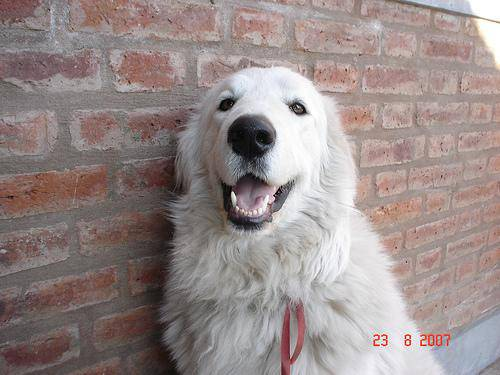

('upright', 0.997549)


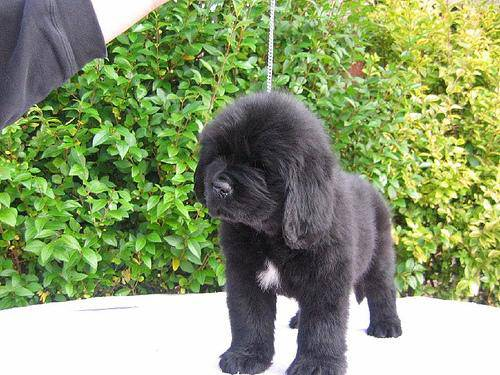

('upright', 0.87916249)


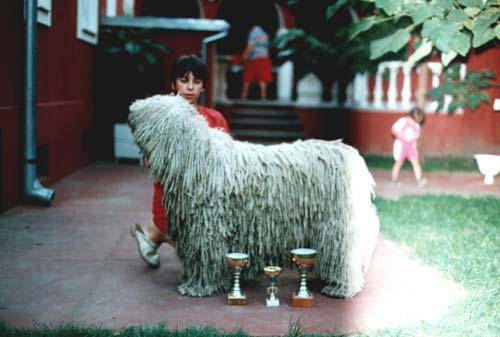

('upright', 0.70665258)


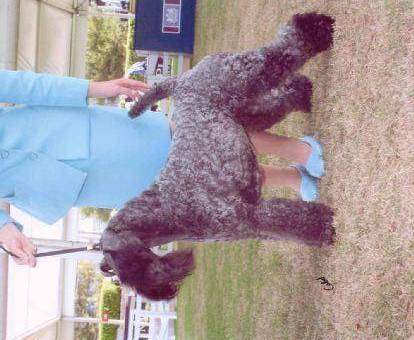

('sideways', 0.95734388)


In [57]:
from IPython.display import Image, display

for i, img_path in enumerate(img_paths):
    display(Image(img_path))
    print(most_likely_labels[i])

## Reference


* [Kaggle Deep Learning Track](https://www.kaggle.com/learn/deep-learning)
    * [Lesson 3: Programming in TensorFlow and Keras](https://www.kaggle.com/dansbecker/programming-in-tensorflow-and-keras)
    * [Lesson 4: Transfer Learning](https://www.kaggle.com/dansbecker/transfer-learning/)
    * [Lesson 5: Data Augmentation](https://www.kaggle.com/dansbecker/data-augmentation)
    
* [What is log loss](https://www.kaggle.com/dansbecker/what-is-log-loss)
* [Stackoverflow: Keras Data Augmentation Parameters](https://stackoverflow.com/questions/41174546/keras-data-augmentation-parameters?rq=1)
* [Keras Blog: Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)